`Team 16 Dự đoán giá vàng bạc bạch kim bằng thuật toán RNN
`

In [20]:
#Cài đặt thư viện 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
import numpy as np 
import pandas as pd 
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
import statsmodels.api as sm
from IPython.display import display, Markdown
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [21]:

df = pd.read_csv('../GoldData.csv', parse_dates=True,)
df

,Ngày,Lần cuối,Mở,Cao,Thấp,KL
0,21/5/2018,1290.9,1290.3,1292.7,1281.2,328.02K
1,22/5/2018,1292.0,1292.3,1296.0,1287.2,291.72K
2,23/5/2018,1289.6,1290.6,1298.4,1286.7,402.34K
3,24/5/2018,1304.4,1293.3,1306.4,1292.2,432.42K
4,25/5/2018,1303.7,1304.0,1307.2,1299.4,292.91K
...,...,...,...,...,...,...
1291,15/5/2023,2018.0,2013.8,2017.1,2013.8,0.00K
1292,16/5/2023,1988.4,2021.3,2022.7,1989.1,0.05K
1293,17/5/2023,1980.7,1983.6,1983.6,1983.6,0.01K
1294,18/5/2023,1956.5,1956.8,1956.8,1956.8,0.02K


In [22]:
#Xem các dữ liệu cơ bản của cảc thuộc tính
df.describe()

,Lần cuối,Mở,Cao,Thấp
count,1296.000000,1296.000000,1296.000000,1296.000000
mean,1657.157253,1657.419946,1668.953858,1645.013889
std,247.037374,247.289166,250.206107,243.663453
min,1184.000000,1180.700000,1189.000000,1167.100000
25%,1467.675000,1465.800000,1473.625000,1459.100000
50%,1751.750000,1751.550000,1761.200000,1735.750000
75%,1841.325000,1840.725000,1853.300000,1828.425000
max,2069.400000,2076.400000,2089.200000,2049.000000


In [23]:
#Kiểm tra dữ liệu rỗng
df.isnull().sum()

Ngày        0
Lần cuối    0
Mở          0
Cao         0
Thấp        0
KL          6
dtype: int64

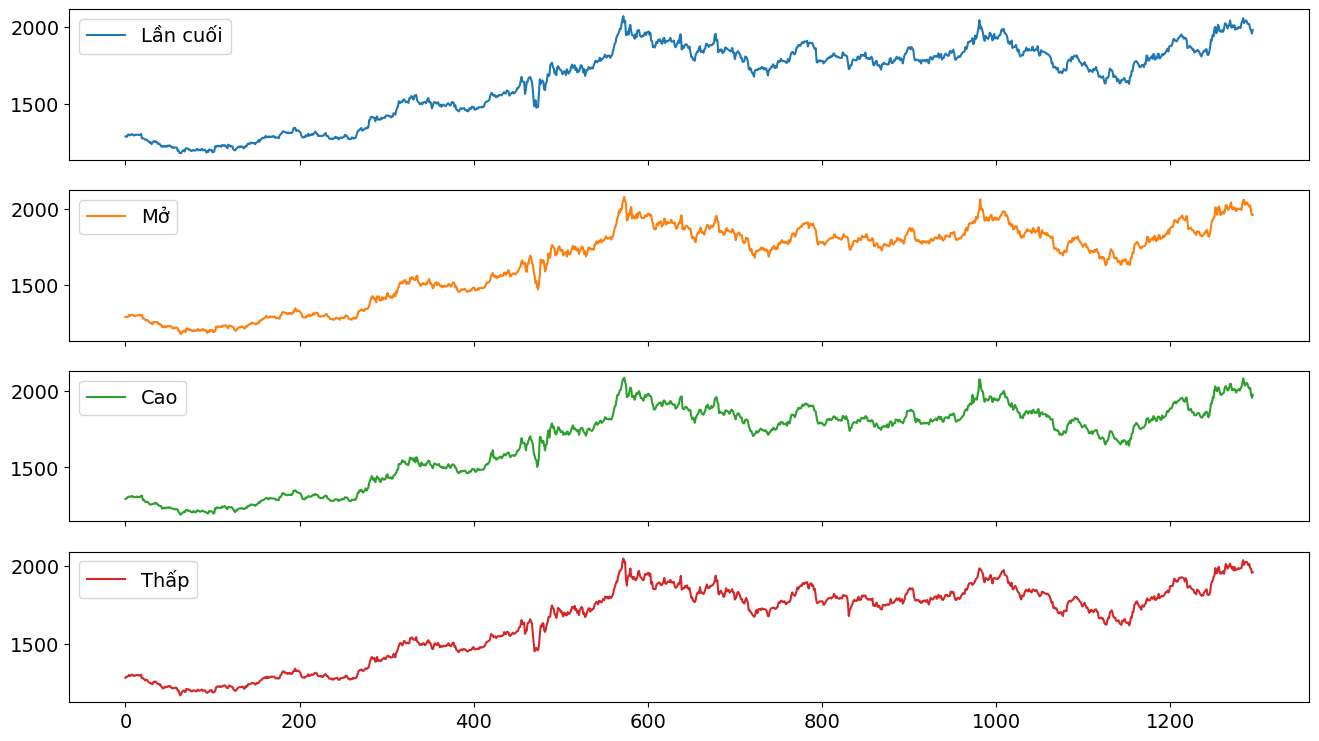

In [24]:
#Xem độ biến thiên của từng thuộc tính.
df.plot(legend=True,subplots=True, figsize = (16, 9))
plt.show()

In [25]:
#Chuyển dataset về cột Close để tiến hành tạo model
df = df[['Lần cuối']]
df

,Lần cuối
0,1290.9
1,1292.0
2,1289.6
3,1304.4
4,1303.7
...,...
1291,2018.0
1292,1988.4
1293,1980.7
1294,1956.5


In [26]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [27]:
#Chia dữ liệu theo các tỷ lệ 7:2:1
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [28]:
#Tạo hàm create dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)

In [29]:
#Chia thành các tập X,y
time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
print(y_train)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)


[6.29094195e-02 4.89044500e-02 4.95821098e-02 4.51773210e-02
 5.31962955e-02 4.69844138e-02 4.68714705e-02 5.39868986e-02
 4.70973571e-02 5.50033883e-02 5.36480687e-02 5.60198780e-02
 4.92432799e-02 4.07725322e-02 4.42737746e-02 3.80618929e-02
 3.87395527e-02 4.17890219e-02 4.05466456e-02 3.95301559e-02
 1.68285521e-02 1.88615315e-02 1.12943302e-03 0.00000000e+00
 2.25886605e-04 1.19719901e-02 1.80709284e-02 2.17980574e-02
 1.12943302e-02 3.30923876e-02 3.61418568e-02 3.43347639e-02
 3.10594082e-02 2.37180935e-02 2.56381297e-02 1.70544387e-02
 1.42308561e-02 1.95391913e-02 2.29274904e-02 1.85227016e-02
 1.78450418e-02 2.05556810e-02 3.03817484e-02 2.73322792e-02
 1.93133047e-02 2.46216399e-02 2.13462842e-02 2.74452225e-02
 3.08335216e-02 1.95391913e-02 2.30404337e-02 2.38310368e-02
 1.70544387e-02 3.84007228e-03 1.37790829e-02 8.69663429e-03
 2.59769596e-02 2.13462842e-02 1.98780212e-02 2.43957533e-02
 5.19539191e-03 8.47074768e-03 1.06166704e-02 4.92432799e-02
 4.29184549e-02 5.229274

In [30]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(20,activation='relu',return_sequences=True,input_shape=(time_step, 1)))
model.add(SimpleRNN(20,activation='relu',return_sequences=True))
model.add(SimpleRNN(20,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [31]:

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,verbose=1)


Epoch 1/100
19/19 [==============================] - 3s 34ms/step - loss: 0.0798 - val_loss: 0.0449
Epoch 2/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0113 - val_loss: 0.0067
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0027 - val_loss: 9.4454e-04
Epoch 4/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0010 - val_loss: 7.5916e-04
Epoch 5/100
19/19 [==============================] - 0s 15ms/step - loss: 8.9722e-04 - val_loss: 7.2691e-04
Epoch 6/100
19/19 [==============================] - 0s 17ms/step - loss: 8.6311e-04 - val_loss: 7.2325e-04
Epoch 7/100
19/19 [==============================] - 0s 15ms/step - loss: 8.3365e-04 - val_loss: 7.1747e-04
Epoch 8/100
19/19 [==============================] - 0s 21ms/step - loss: 8.2571e-04 - val_loss: 7.5332e-04
Epoch 9/100
19/19 [==============================] - 0s 18ms/step - loss: 8.4944e-04 - val_loss: 7.2677e-04
Epoch 10/100
19/19 [==============================] 

In [32]:

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)


7/7 [==============================] - 0s 5ms/step


In [33]:

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
y_test=scaler.inverse_transform(y_test.reshape(-1,1))
y_val=scaler.inverse_transform(y_val.reshape(-1,1))


In [34]:
# Đánh giá 
def deviation(test, pred):
  rmse= np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape= mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mae = mean_absolute_error(test, pred)
  print(f"MAE: {mae:.2f}")

In [35]:
#Hàm visualize
def visualize(label ,pred, model_name):
  plt.figure(figsize=(12,8))
  plt.plot(label, label = 'Ground truth')
  plt.plot(pred, label='Predict')
  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

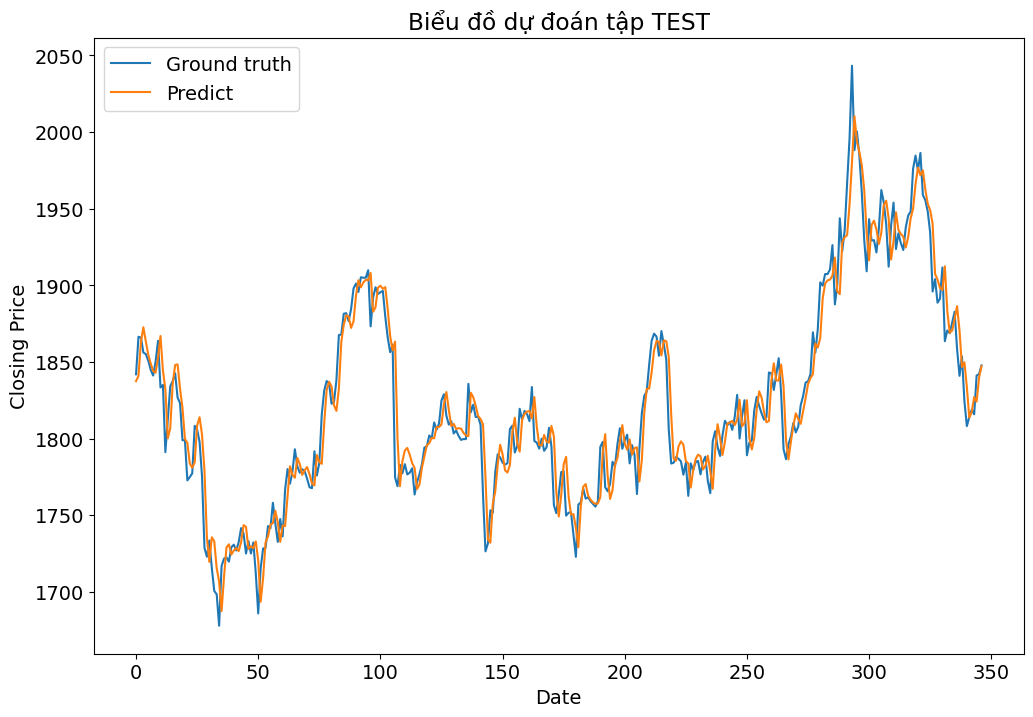

Đánh Giá tập TEST
RMSE: 17.66
MAPE: 0.71%
MAE: 12.98


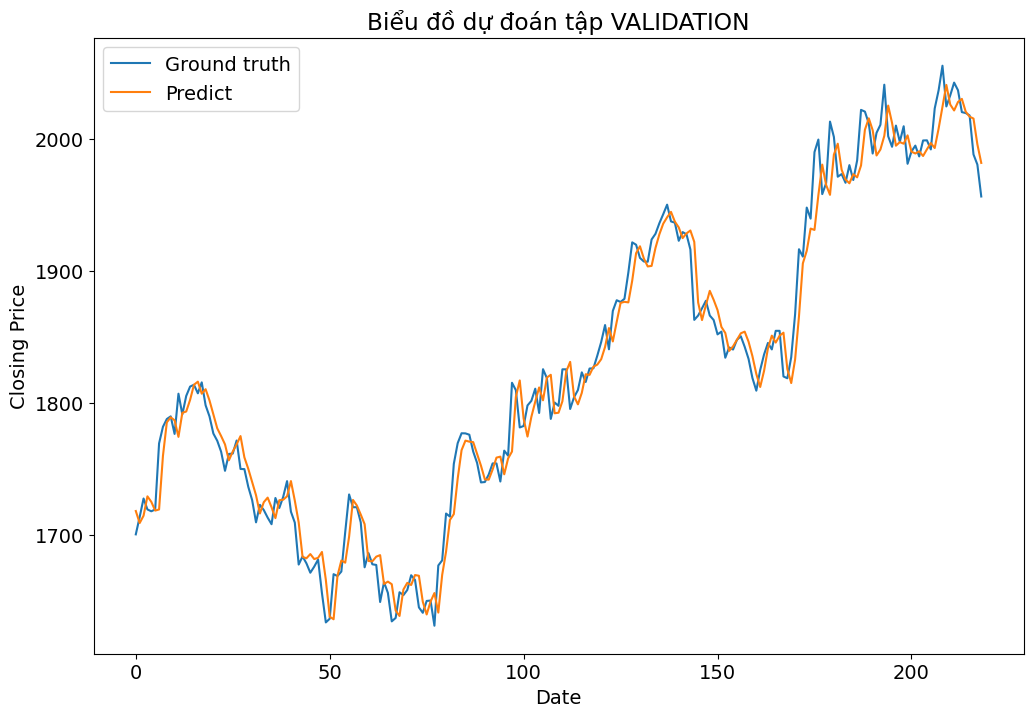

Đánh Giá tập VALIDATION
RMSE: 18.45
MAPE: 0.76%
MAE: 13.82


In [36]:
# visualize(y_train,y_pred_train,'Biểu đồ dự đoán tập TRAIN')
visualize(y_test,y_pred,'Biểu đồ dự đoán tập TEST')
print('Đánh Giá tập TEST')
deviation(y_test, y_pred)

visualize(y_val,y_pred_val,'Biểu đồ dự đoán tập VALIDATION')
print('Đánh Giá tập VALIDATION')
deviation(y_val, y_pred_val)

In [37]:

val_len=len(val_data)
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=val_len-60
i=0
while(i<30):
        
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.8934827]
201
1 day input [0.66320307 0.65382878 0.637452   0.65190874 0.65224757 0.66342896
 0.63903321 0.63892026 0.62378586 0.61237859 0.59329117 0.60831263
 0.60385137 0.59735713 0.59170996 0.61418568 0.60560199 0.61508923
 0.62864242 0.60243958 0.59306528 0.55714931 0.5641518  0.5581658
 0.55014683 0.55534222 0.56144116 0.53264061 0.5075672  0.51072961
 0.54890445 0.54732324 0.55116332 0.58504631 0.61723515 0.60627965
 0.60627965 0.59329117 0.5547775  0.56697538 0.5573752  0.55681048
 0.52507341 0.54212785 0.5328665  0.50847075 0.51140727 0.53343122
 0.53094646 0.53535125 0.5480009  0.54393494 0.52044274 0.51581206
 0.52597696 0.52631579 0.50474362 0.55635871 0.5607635  0.60085837
 0.59826067 0.64343799 0.66117009 0.66964084 0.6695279  0.66839846
 0.65394172 0.6442286  0.62751299 0.62785182 0.63428959 0.64377682
 0.64377682 0.62830359 0.65473232 0.65044048 0.71289813 0.7065733
 0.67461035 0.67585272 0.69347188 0.69742489 0.70781568 0.68703411
 0.72453129 0.71685114 0.68195166 0.

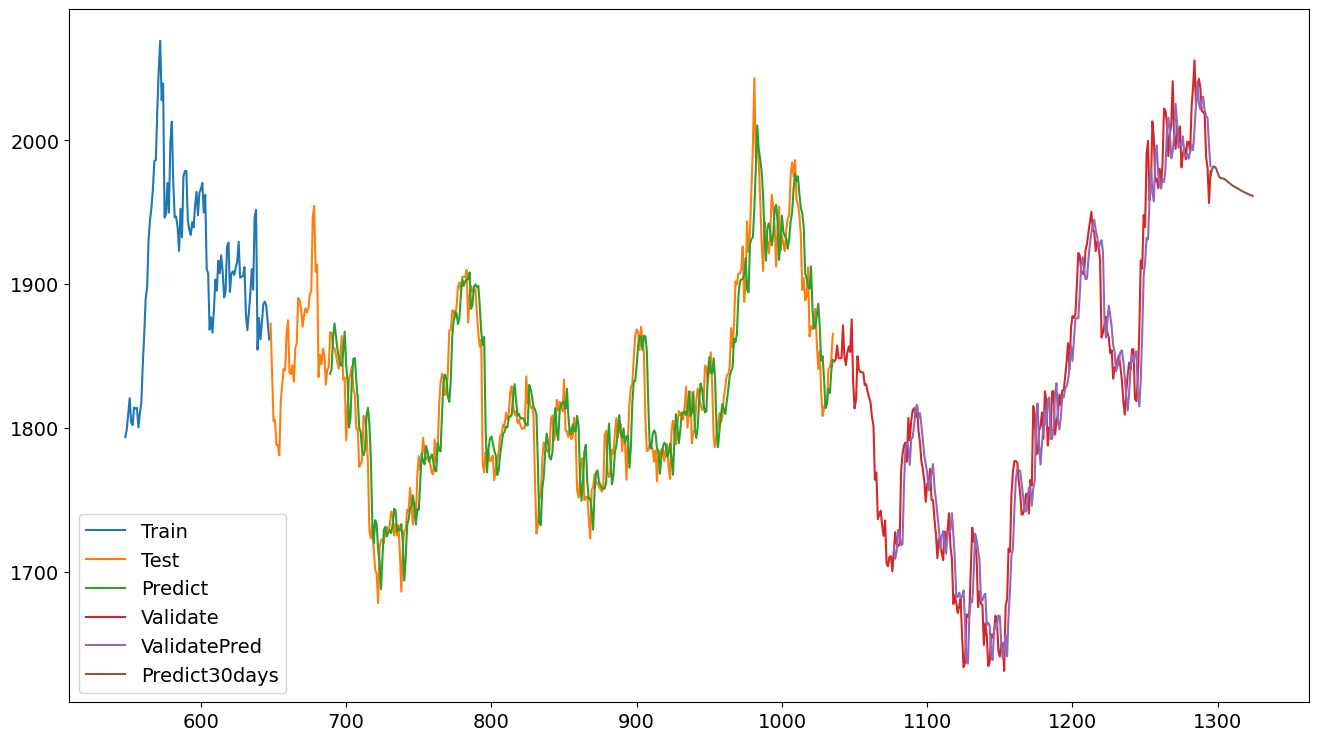

In [38]:
# Vẽ hình
plt.figure(figsize=(16,9))

train_data_index = pd.RangeIndex(start=train_size-100, stop=train_size, step=1)
plt.plot(train_data_index,scaler.inverse_transform(train_data[train_size-100:]))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+ 41, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

val_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size + test_size+ 41, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)


prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()